## Análisis de fraude en tarjetas de crédito

#### El fraude como problema a modelizar

Se trata de un evento binario que se podría modelizar con una regresióm logística como cualquier otro: dada una variable <b>y</b> que sigue una distribución de Bernoulli <b>B(p)</b>, se construye un modelo que modeliza <b>p(y=1)</b> a partir de ciertas variables independientes, es decir, que modeliza <b>p(y=1|x1,.....,xk)</b>. El modelo estimado sería de la forma 

$\hat{p}(y=1|x_1,...,x_k)=1/(1+e^{-(\hat{b_0}+\hat{b_1}·x_1+...+\hat{b_k}·x_k)})$.

Las principales particularidades respecto a otros eventos binarios son las siguientes: 

* Problema muy desbalanceado: muy pocos malos respecto a muchos buenos.
* Las técnicas de fraude evolucionan constantemente, a medida que se detectan, por lo que puede ser necesario estimar nuevos modelos con muestras muy recientes con cierta frecuencia (incluso automatizar los reentrenamientos).

Ejemplos en el contexto de banca: 

* <b>Transacciones fradulentas (no autorizadas) en tarjetas (digital o duplicada</b>.
* Phishing
* Cuentas mula.
* Fraude documental
* Modelos "never inteded to pay".

En banca, se trata de un problema que puede generar, aparte de pérdidas directas o por sanciones regulatorias, un importante riesgo reputacional.

En esta sesión nos vamos a centrar en el primer caso (transacciones fradulentas). La manera aleatoria de combatir este problema sería revisando (pidiendo una doble verificación, o directamente bloqueando la transacción) aleatoriamente <b>n</b> de las <b>N</b> transacciones, detectando aproximadamente <b>p · n</b> casos de fraude, donde <b>p</b> es la tasa de fraude en la población total; no se puede pedir una doble verificación de todas las transacciones porque desincentivaría el usto de la tarjeta. El objetivo al introducir un modelo sería poder, o bien revisando el mismo número de casos aumentar significativamente los fraudes detectado, o bien detectar un número similar de casos reducidendo significativamente los que revisan (trade-off).

#### Enfoques planteados

A continuación se introducen los distintos enfoques que se van a utilizar para modelizar la detección de fraude en transacciones de tarjetas:

* Detección de outliers
* Clustering
* Regresión Logística, árbol de decisión u otro modelo de aprendizaje supervisado
* técnicas para clases desbalanceadas

### 1. Análisis exploratorio de datos

#### Importar librerias

In [361]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


#### Carga de datos

Este fichero contiene información sobre transacciones de tarjetas de crédito realziadas durante dos días consecutivos de septiembre de 2023 en un banco europeo:; si son fradulentas o no (nuestra variable y) e inforamción sobre la transacción y su titular.

Las variables son todas numércias y ya se ha realizado un análisis de componentes princiaples (PCA) sobre ellas, por lo que se simplifica el proceso. Las únicas variables que no son PCs son Time (tiempo desde la primera transacción a la siguiente, en segundos) y Amount(importe de la transacción).

Las variables originales que se han transformado a PCs pueden contener información sobre e titular, el destinatario, la localización, fecha de emisión y de caducidad, si es una transaccción en un medio físico o digital...

El PCA es una téncica de analisis estadístico y de aprendizaje automatico que se utiliza para recudir la dimensionalidad de un conjunto de datos, manteniendo la mayor cantidad posible de información importante. 

Los PCs son combinaciones lineales de las variables originales y están ordenadas de manera que la primera PC explica la mayor cantidad de variabilidad (varianza) en los datos, la segunda PC explica la mayor parte de la variabilidad (varianza) restante, y así sucesivamente.

In [363]:
tarjetas = pd.read_csv("C:/Users/pauri/OneDrive/Escritorio/PYTHON PROJECTS/CUA Big Data/creditcard.csv")
tarjetas.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


* id = identificador para cada transacción
* V1-V28 = Características anonimizadas que representan diversos atributos de transacciones ( por ejemplo, tiempo, ubicación, etc)
* Amount = cantidad de la transacción
* Class = (1) fradulente (0) no fradulenta

In [365]:
tarjetas.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

#### Análisis univariante

In [367]:
tarjetas.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Como se indicaba, estas variables (excepto la cantidad y el tiempo) son PCs, de media 0 (porque estan estandarizadas), y ya aparecen ordenadas por varianza (por la varianza que explican de los datos originales).

In [369]:
# Extraemos las varianzas del DataFrame Tarjetas de los valores V1-V28
varianzas_pcs=tarjetas.var().iloc[1:-2]
varianzas_pcs

V1     3.836489
V2     2.726820
V3     2.299029
V4     2.004684
V5     1.905081
V6     1.774946
V7     1.530401
V8     1.426479
V9     1.206992
V10    1.185594
V11    1.041855
V12    0.998403
V13    0.990571
V14    0.918906
V15    0.837803
V16    0.767819
V17    0.721373
V18    0.702539
V19    0.662662
V20    0.594325
V21    0.539526
V22    0.526643
V23    0.389951
V24    0.366808
V25    0.271731
V26    0.232543
V27    0.162919
V28    0.108955
dtype: float64

In [370]:
# Extraemos el porcentaje explicativo de cada una de las variables para explicar la variabilidad de los datos
varianzas_pcs/varianzas_pcs.sum()

V1     0.124838
V2     0.088729
V3     0.074809
V4     0.065231
V5     0.061990
V6     0.057756
V7     0.049799
V8     0.046417
V9     0.039275
V10    0.038579
V11    0.033901
V12    0.032488
V13    0.032233
V14    0.029901
V15    0.027262
V16    0.024984
V17    0.023473
V18    0.022860
V19    0.021563
V20    0.019339
V21    0.017556
V22    0.017137
V23    0.012689
V24    0.011936
V25    0.008842
V26    0.007567
V27    0.005301
V28    0.003545
dtype: float64

In [371]:
# Porcentaje de la variabilidad de los datos acumulado
np.cumsum(varianzas_pcs/varianzas_pcs.sum())

V1     0.124838
V2     0.213567
V3     0.288376
V4     0.353608
V5     0.415598
V6     0.473354
V7     0.523153
V8     0.569570
V9     0.608845
V10    0.647423
V11    0.681325
V12    0.713812
V13    0.746045
V14    0.775946
V15    0.803208
V16    0.828192
V17    0.851665
V18    0.874526
V19    0.896088
V20    0.915427
V21    0.932983
V22    0.950120
V23    0.962809
V24    0.974745
V25    0.983587
V26    0.991153
V27    0.996455
V28    1.000000
dtype: float64

Text(0.5, 1.0, 'Varianza explicada y varianza explicada acumulada por PC')

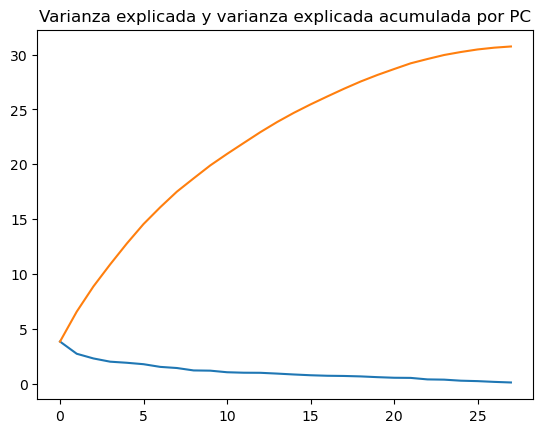

In [372]:
# Graficamos
plt.plot(range(28), varianzas_pcs)
plt.plot(range(28),np.cumsum(varianzas_pcs))
plt.title("Varianza explicada y varianza explicada acumulada por PC")

Las 7 primeras variables explican el 505 de la varianza, las 15 primeras el 80% y las 20 primeras el 90%. 

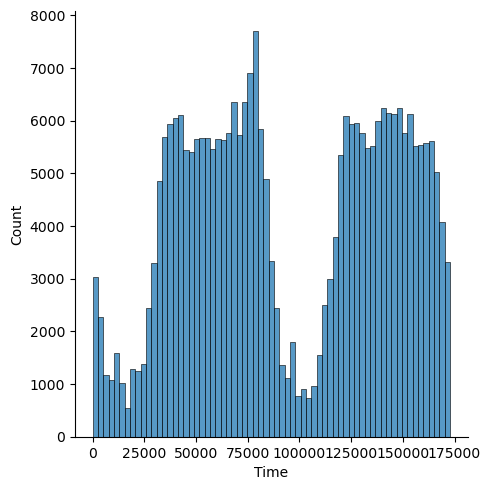

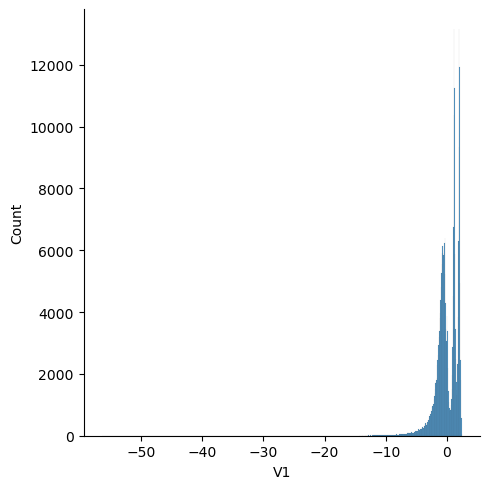

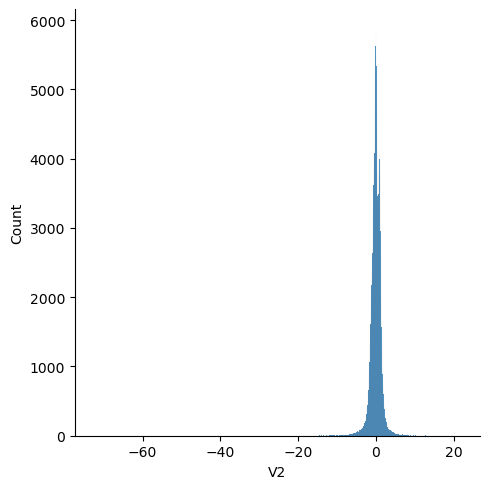

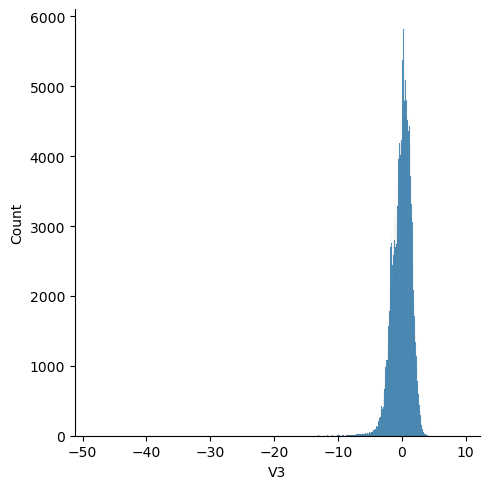

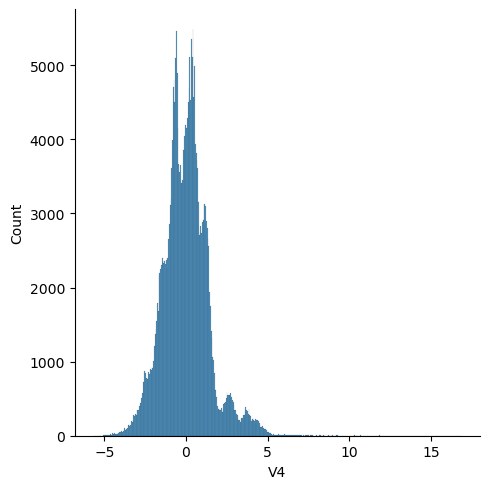

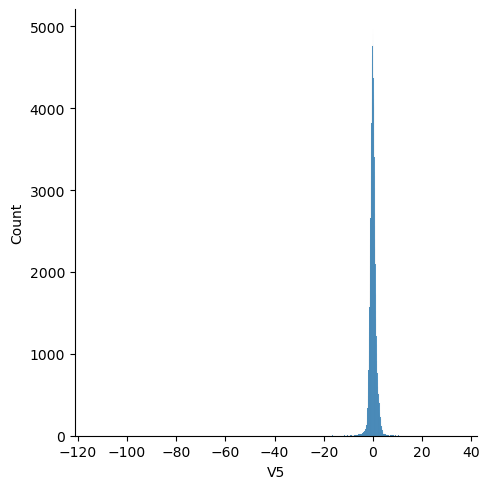

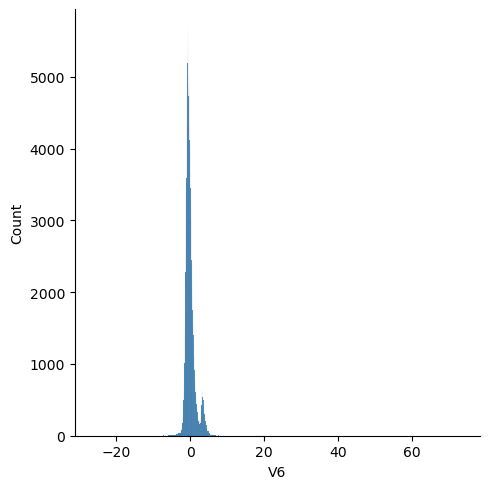

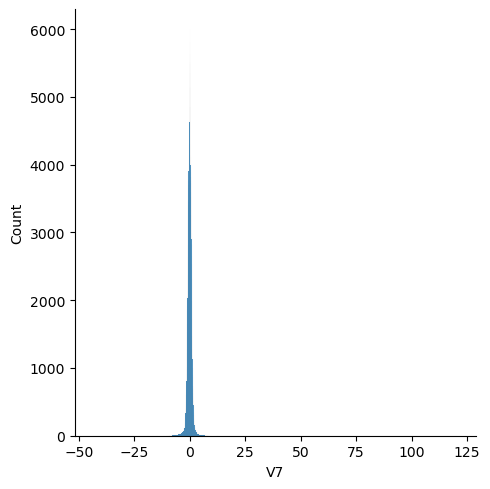

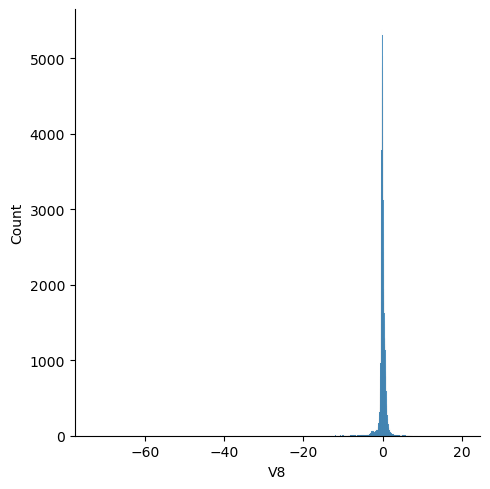

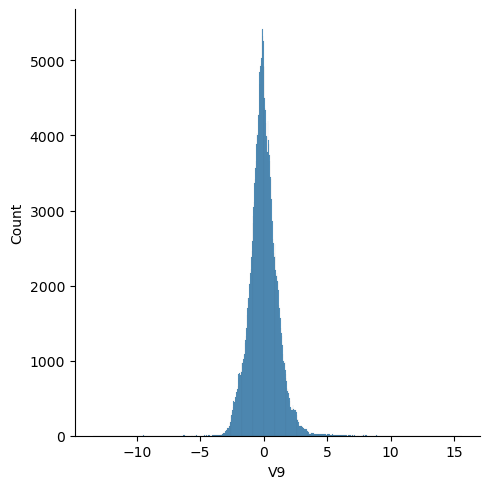

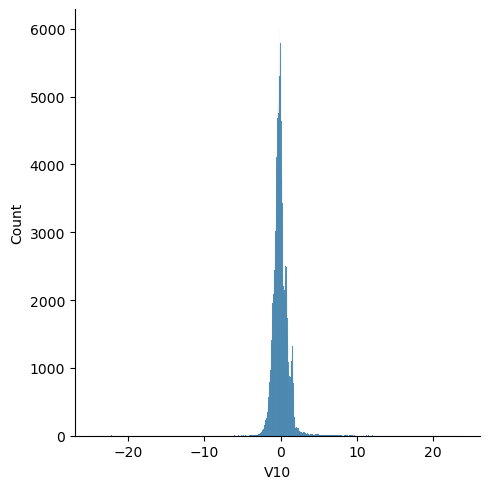

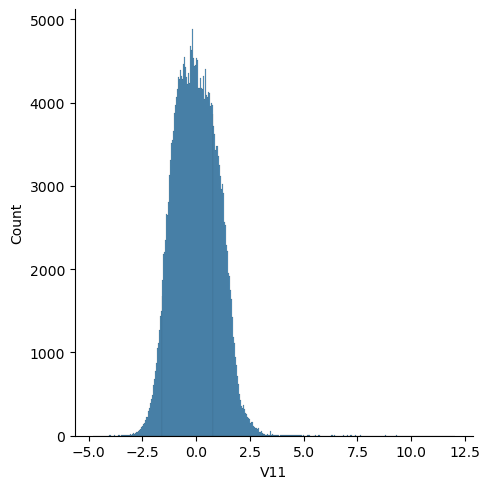

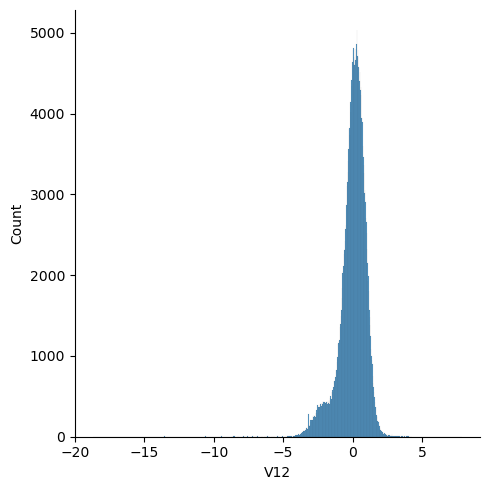

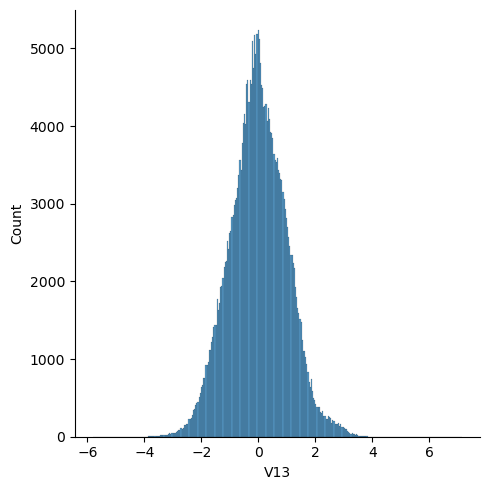

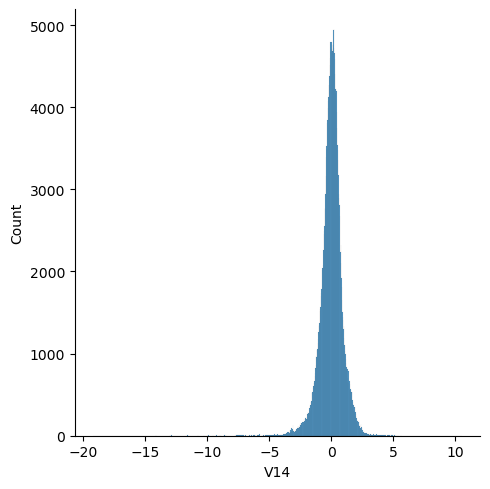

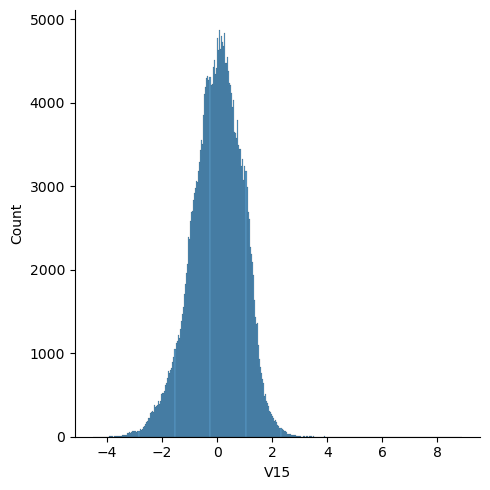

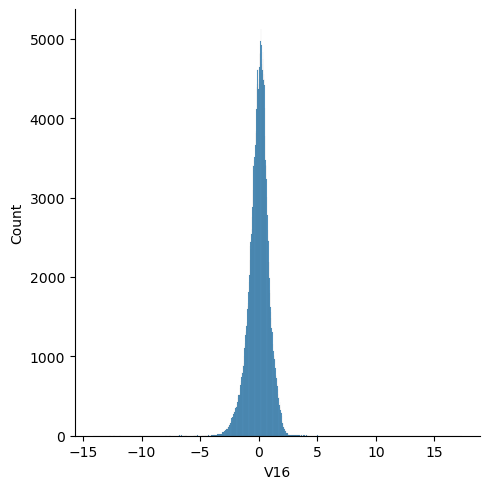

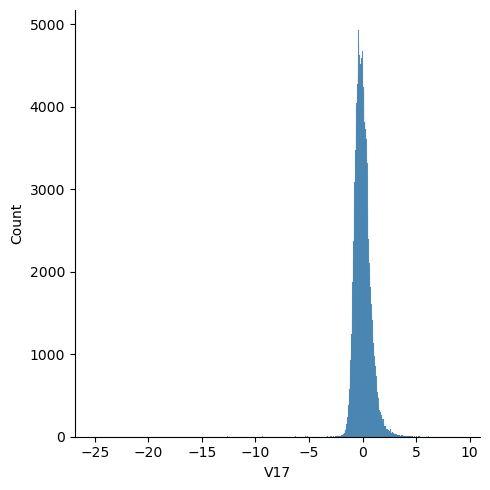

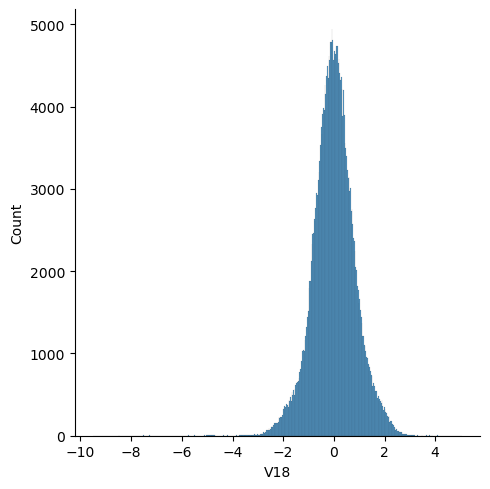

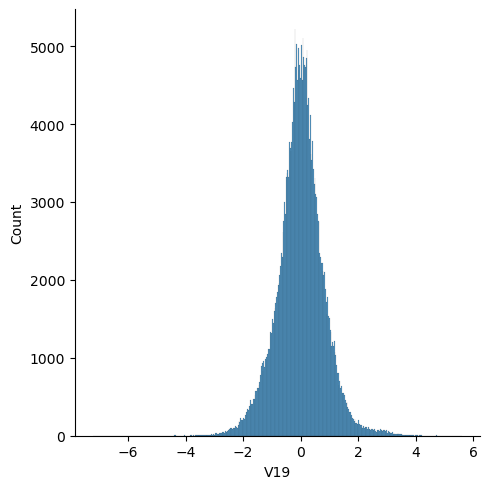

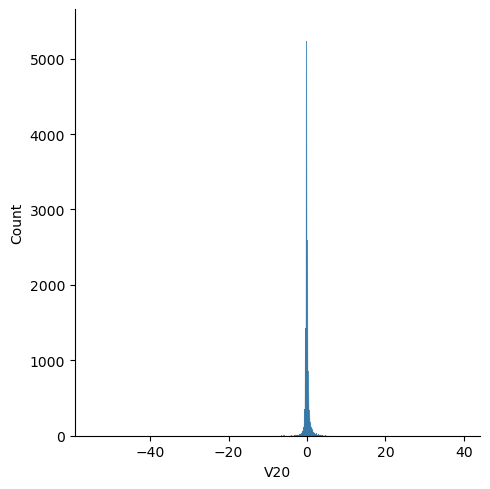

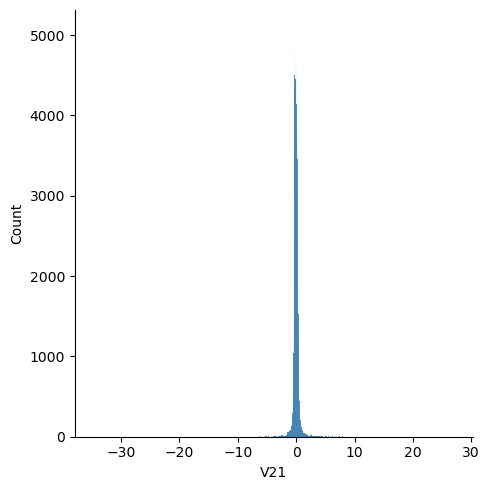

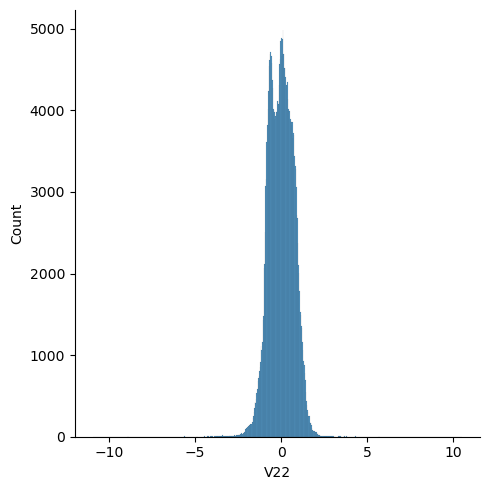

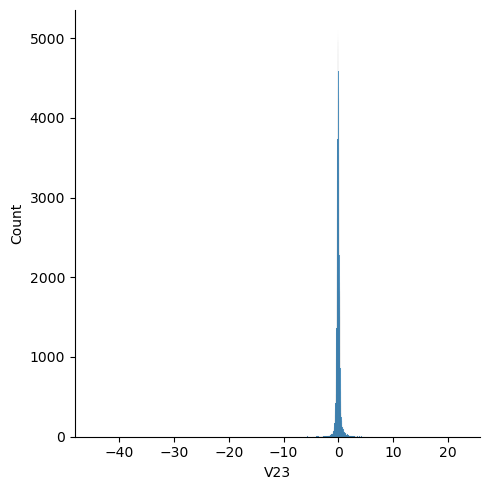

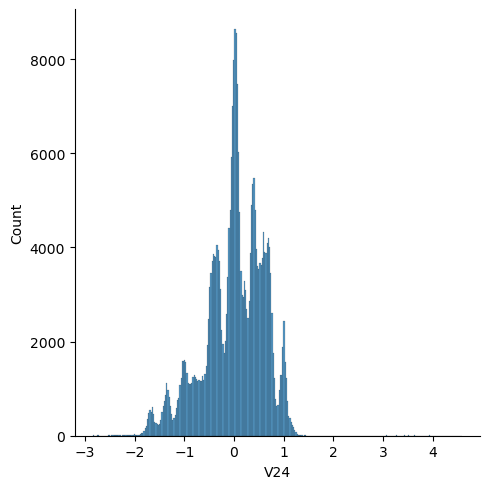

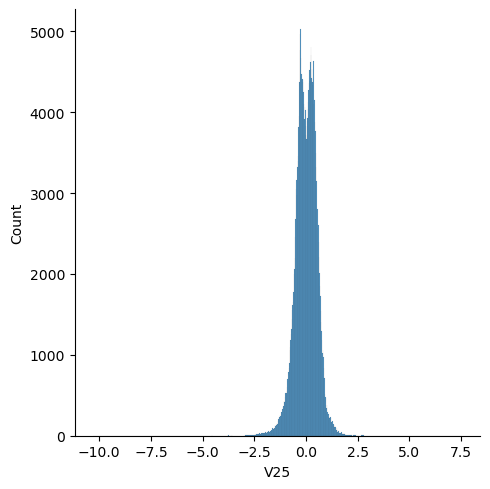

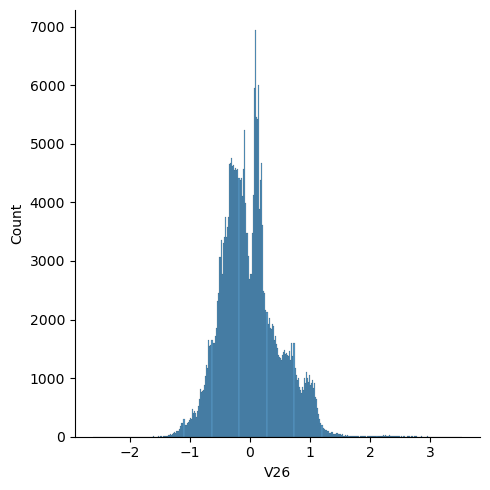

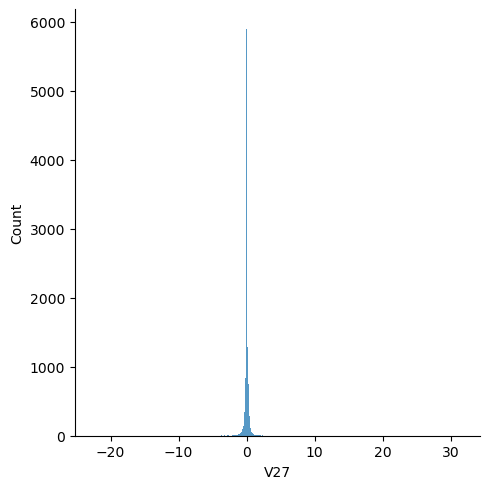

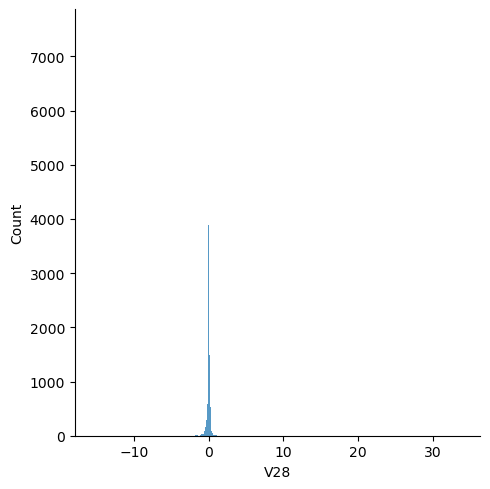

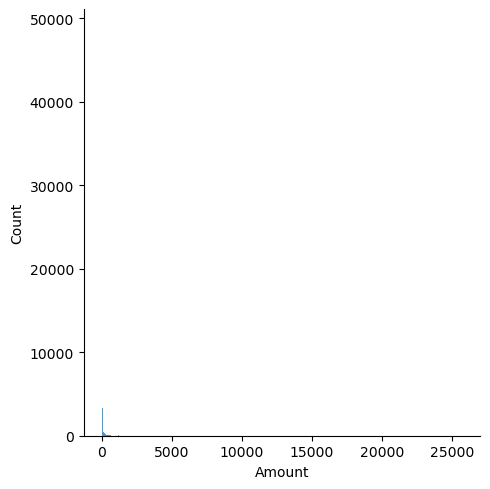

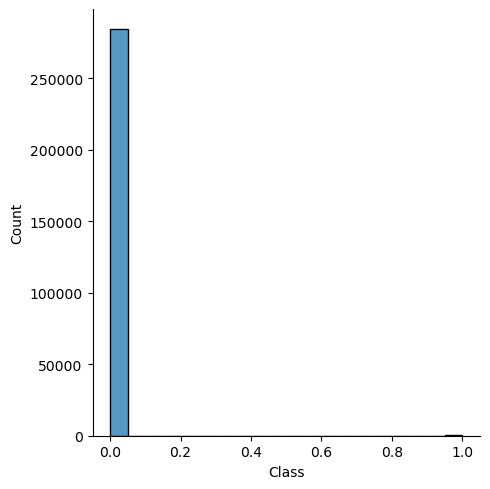

In [374]:
# Distribuciones univariantes de las variables

for i in tarjetas.columns:
    sns.displot(tarjetas[i])
    plt.show()
    

En algunas variables, los ejes del histograma no parecen adecuados. Esto sucede debido a que existen outliers muy lejanos del resto de la distribución, y el histograma tiene que considerarlos. En otros casos, las distribuciones parecen más normales y con menso outliers.

#### Análisis bivariante

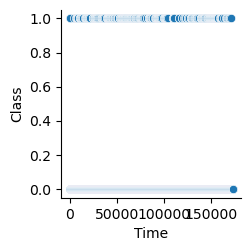

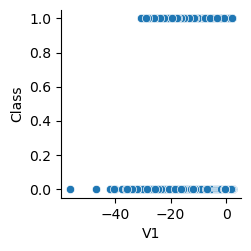

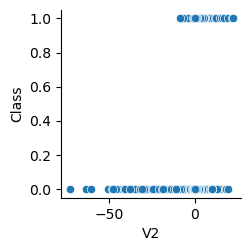

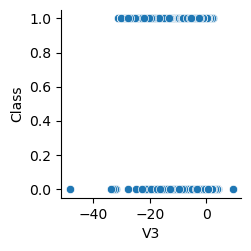

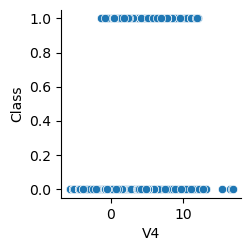

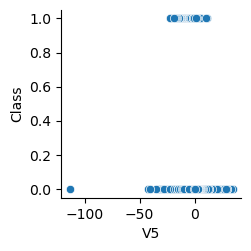

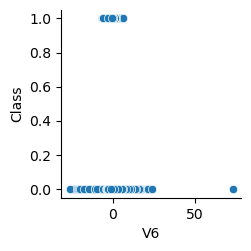

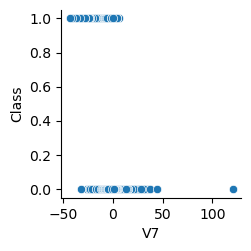

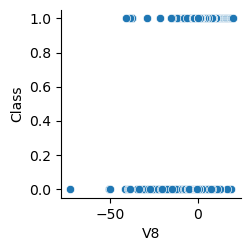

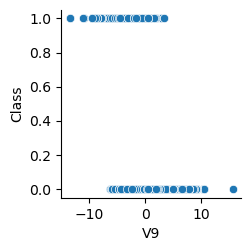

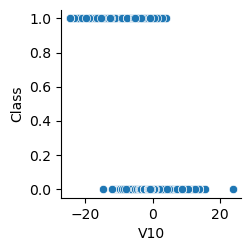

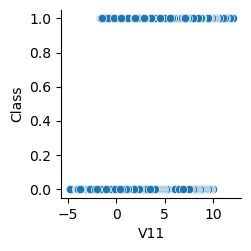

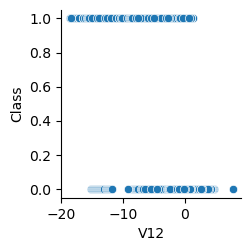

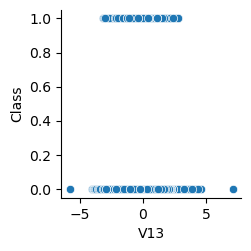

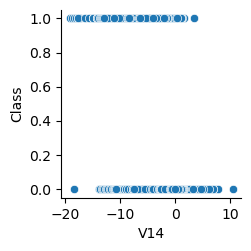

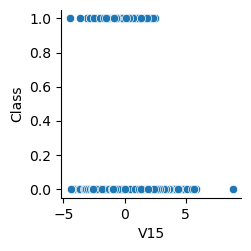

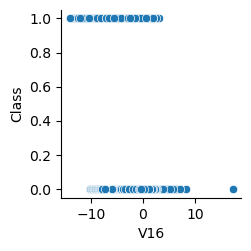

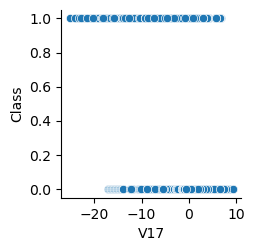

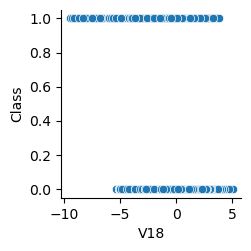

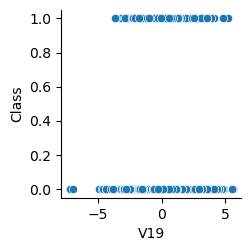

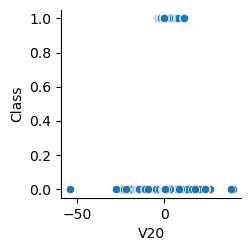

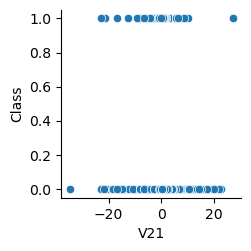

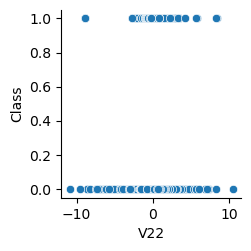

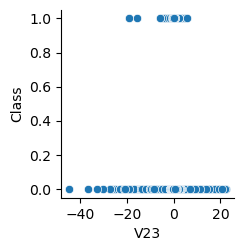

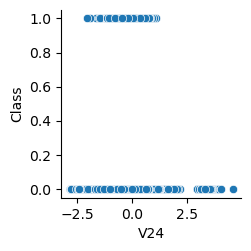

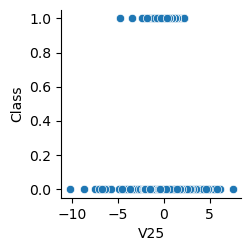

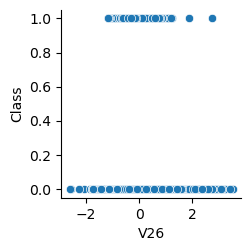

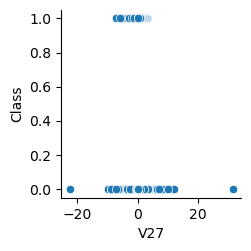

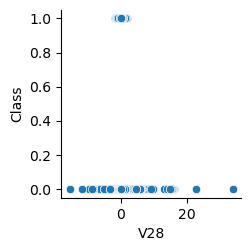

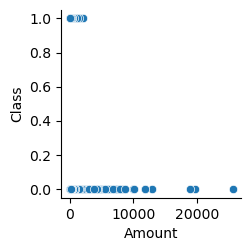

In [377]:
# Distribución bivariante de las variables contra la variables class

for i in tarjetas.iloc[:,0:-1].columns:
    sns.pairplot(tarjetas,x_vars=i,y_vars="Class")
    plt.show()

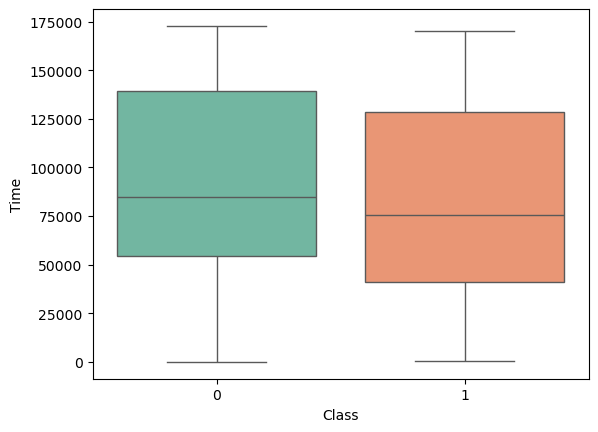

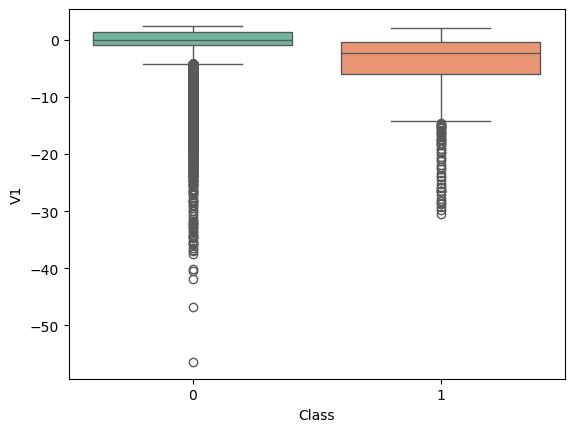

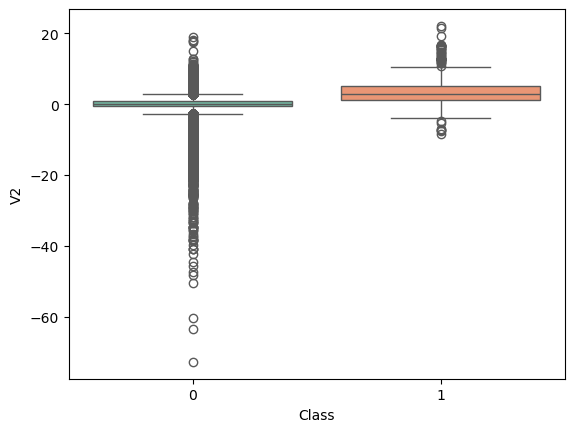

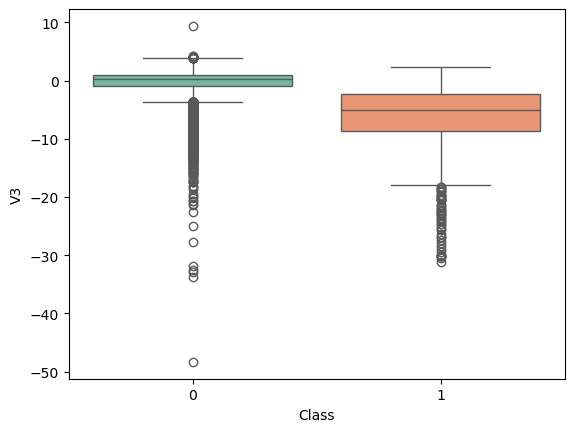

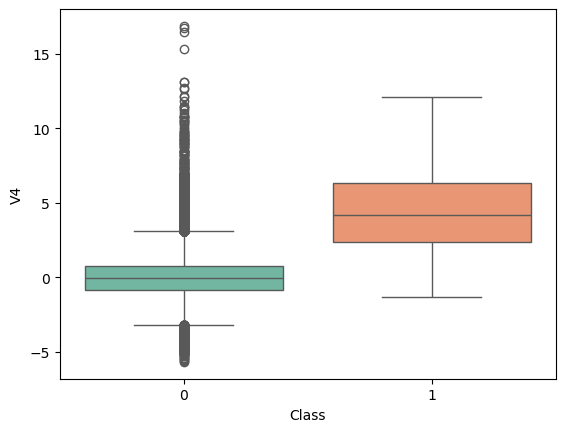

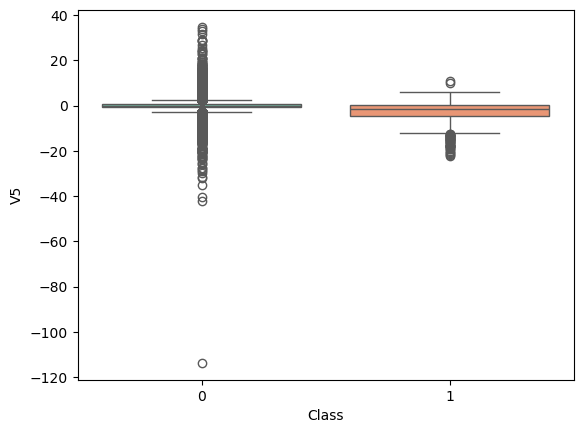

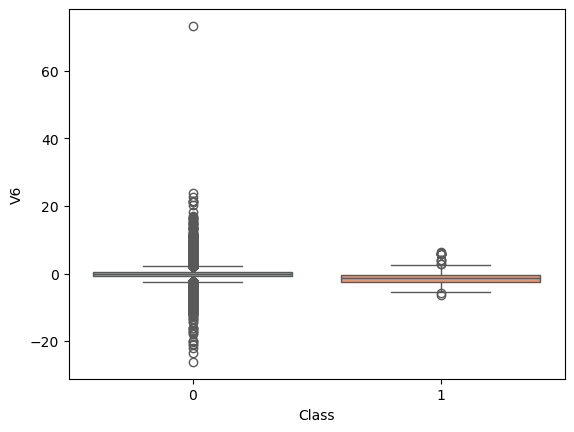

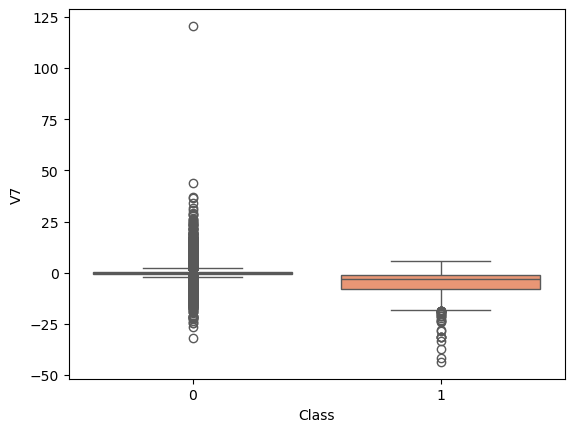

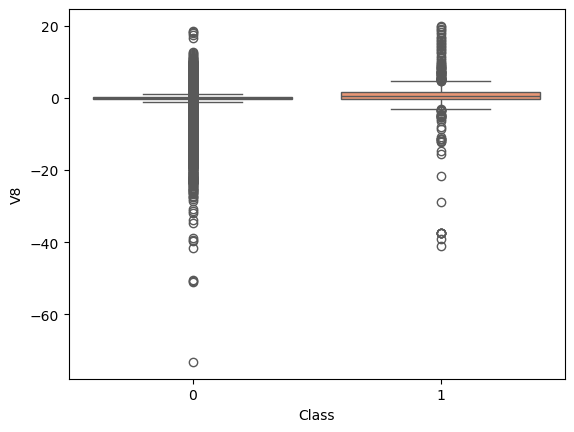

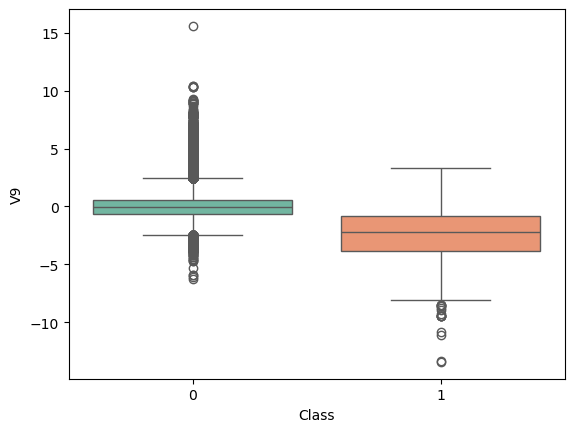

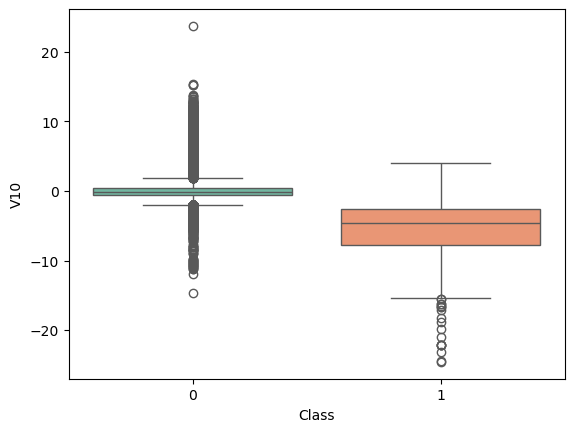

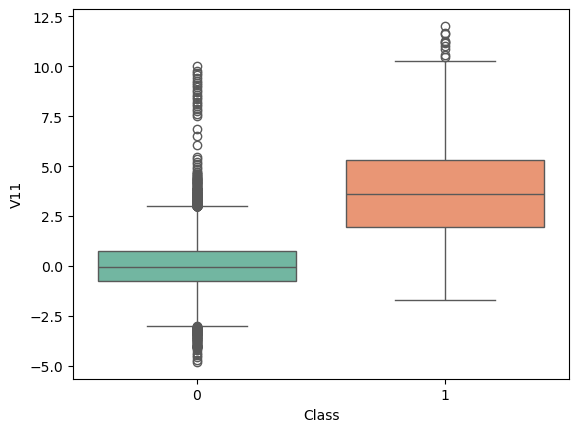

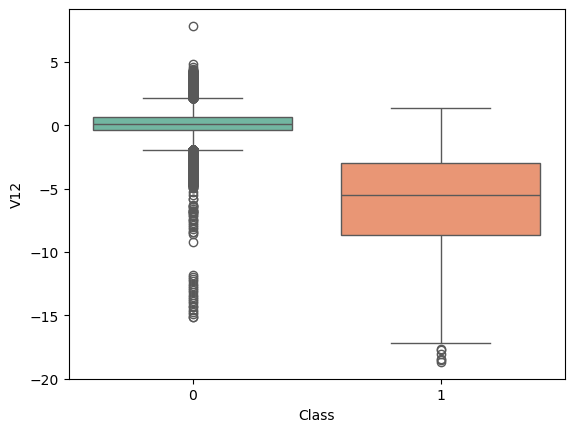

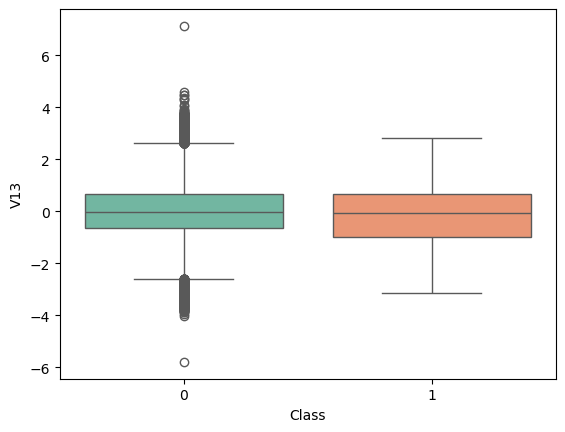

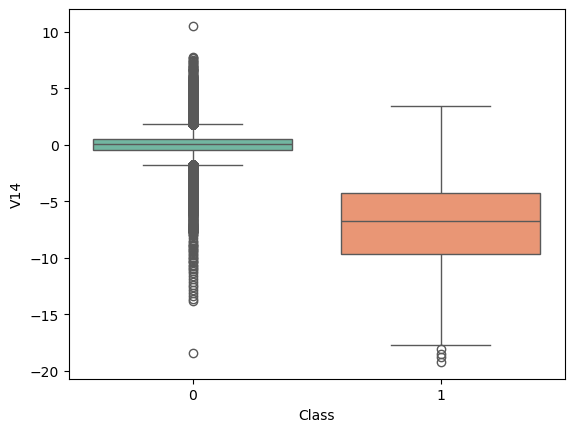

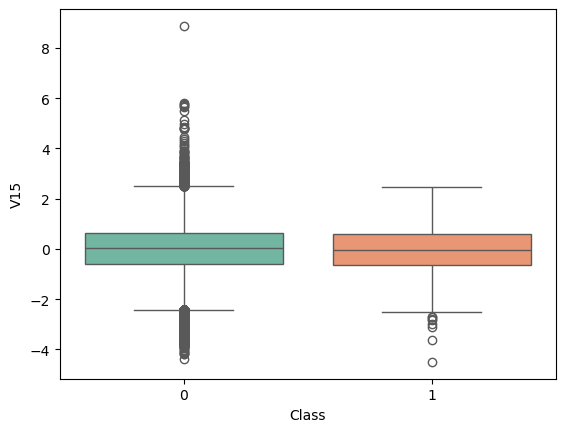

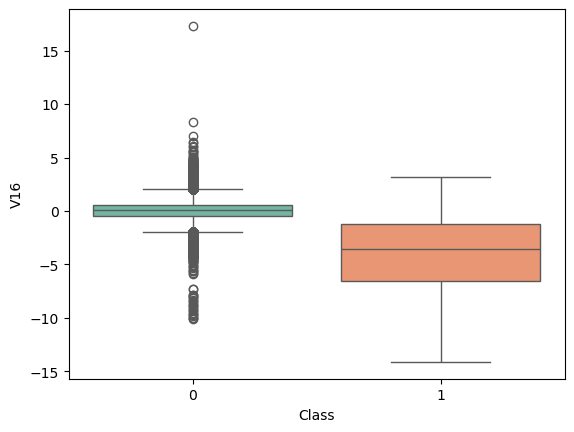

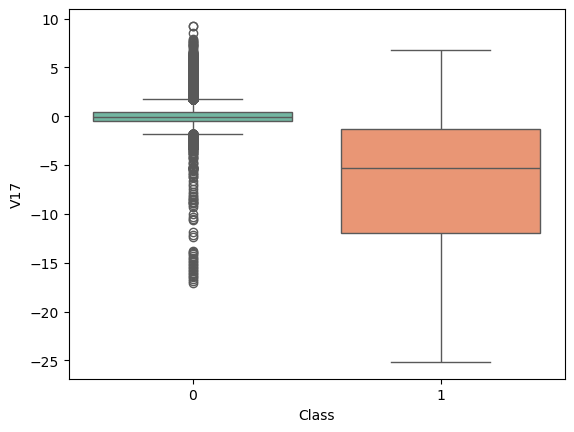

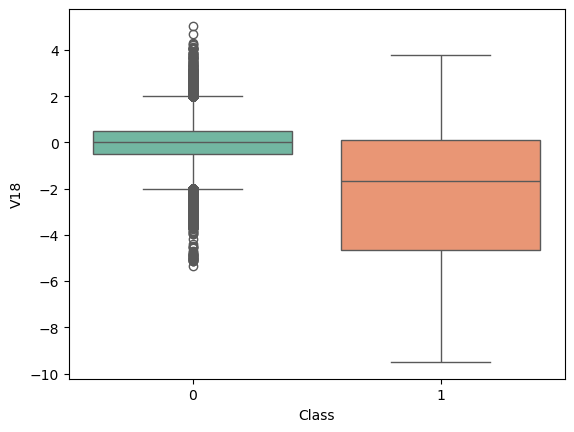

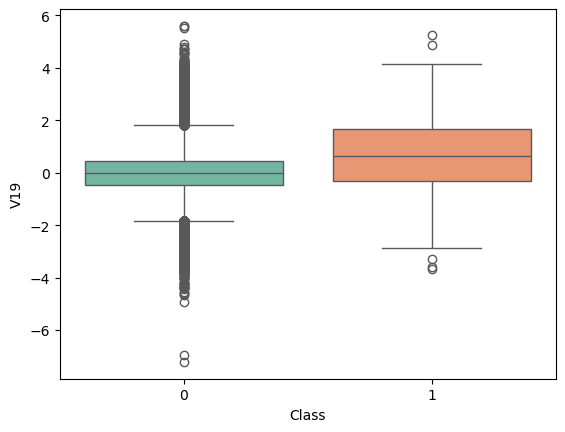

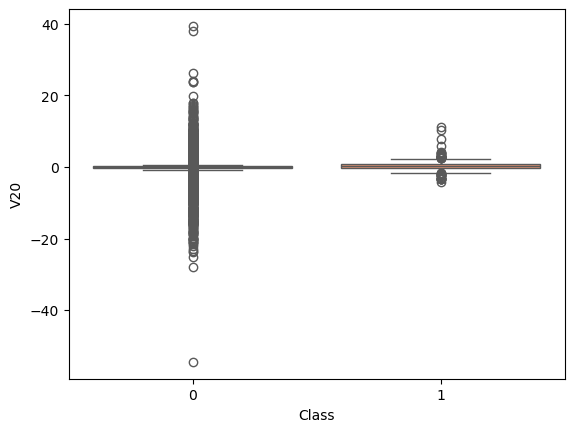

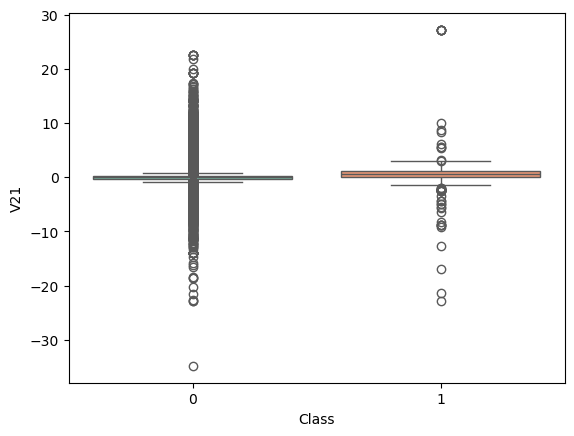

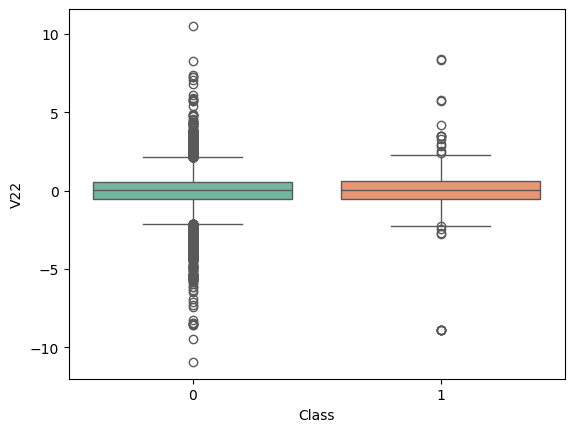

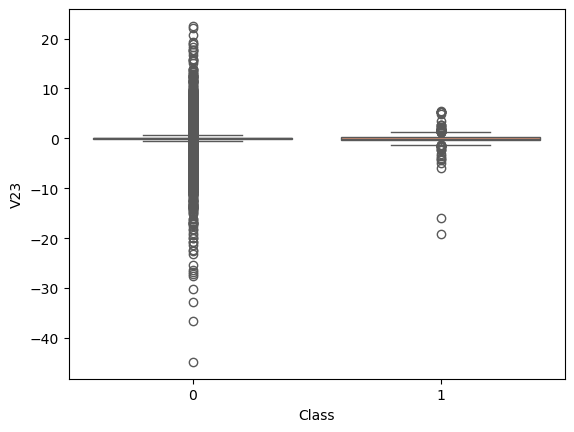

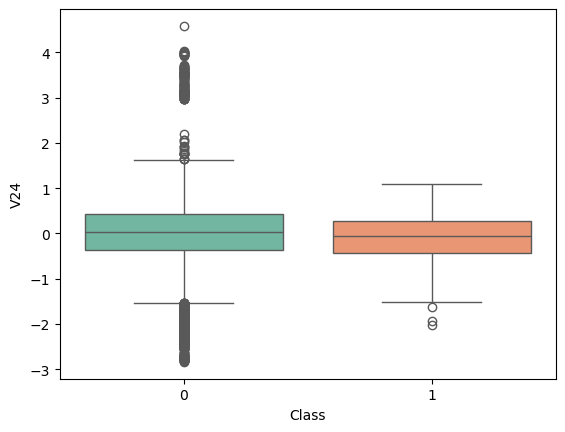

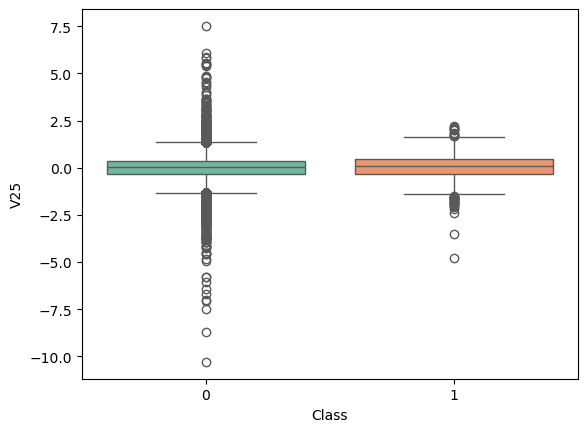

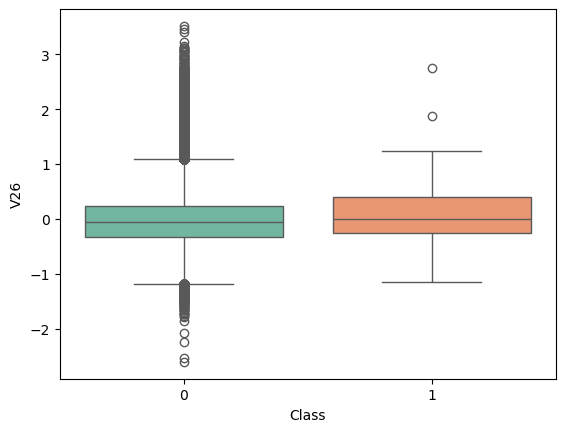

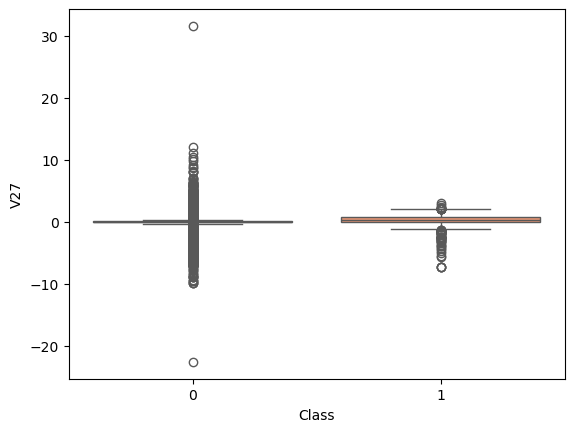

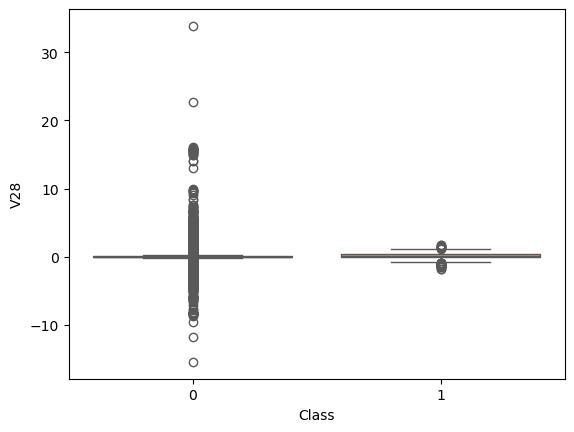

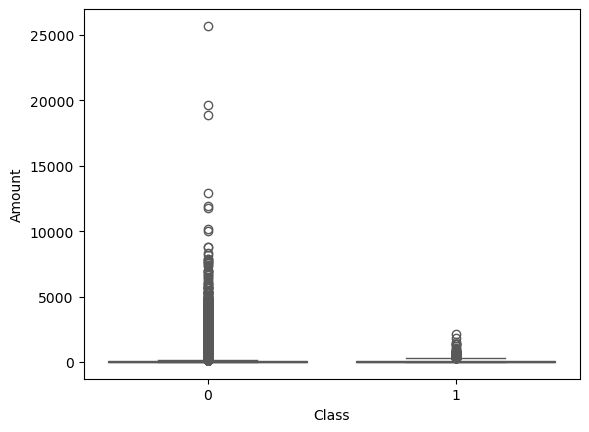

In [378]:
# Boxplot por clase

for i in tarjetas.iloc[:,0:-1].columns:
    sns.boxplot(x="Class",y=i,data=tarjetas,palette="Set2")
    plt.show()

Se osberva que en bastantes de las variables, la distribución en la clase de malos es diferente a la distribución en la clase de buenos

In [380]:
# Correlación de las variables, para ver como correlan con price

tarjetas.corr()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


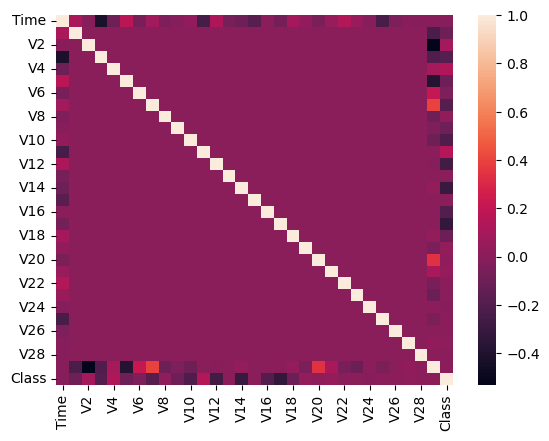

In [381]:
# Mapa de correlación de las variables
sns.heatmap(tarjetas.corr())
plt.show()

Al ser PCs, las correalciones entre todas las variables son 0 (excepto en las variables amount y class)

### 2. Feature engineering

Se van a modificar dos variables: para el Amount, se va a transformar la variable a su logaritmo para reducir la escala, mientras que para el momento de la transacción, en primer lugar se van a agregar las transacciones que corresponden al mismo momento (del primer día o segundo día), y a continuación  se va a tramear la variable por horas.

#### Variable time 

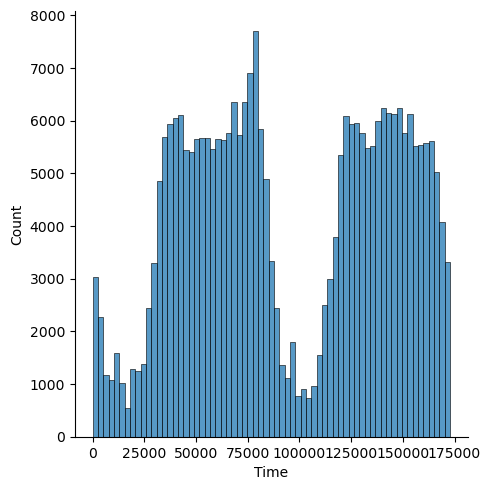

In [385]:
# Distribución de Time
sns.displot(tarjetas["Time"])
plt.show()

Generamos una nueva variable que sea el módulo de 86400 (24:60:60) de la variable Time, para llevar al mismo valor las transacciones que corresponden al mismo momento, pero de los dos días que tenemos. 

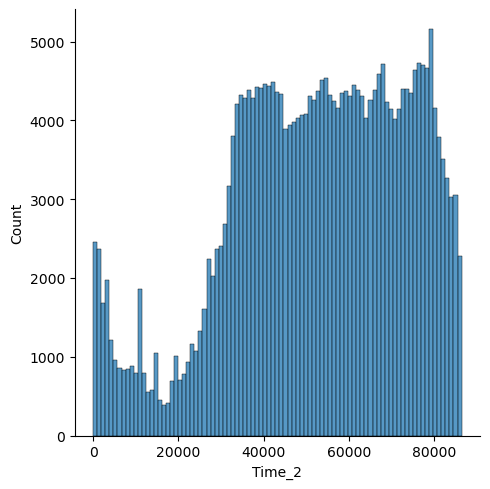

In [387]:
# Separamos entre día uno y dia 2
tarjetas["Time_2"] = tarjetas["Time"]%86400

sns.displot(tarjetas["Time_2"])
plt.show()

Por la forma de la distribución seguramente la variable empiece a contar a las 00:00:00 del primer día. Vamos a generar una variable que indique la hora de la transacción (0-23)

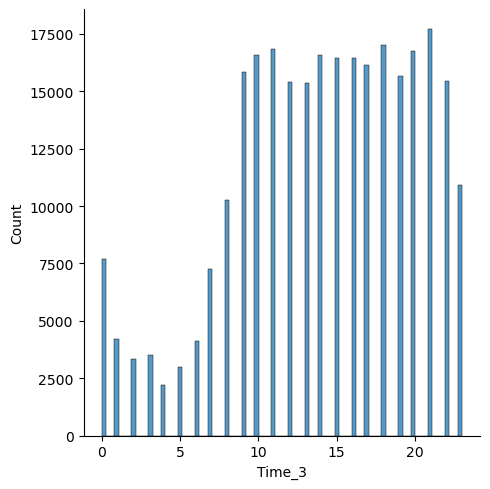

In [389]:
# Separamos por horas
tarjetas["Time_3"] = tarjetas["Time_2"]//3600

sns.displot(tarjetas["Time_3"])
plt.show()

Estudiamos la distribución cruzada de ambas variables

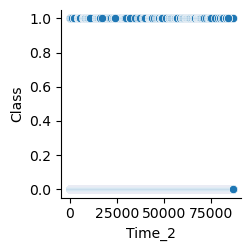

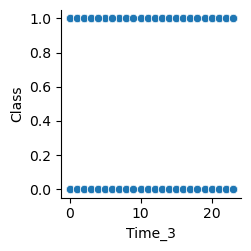

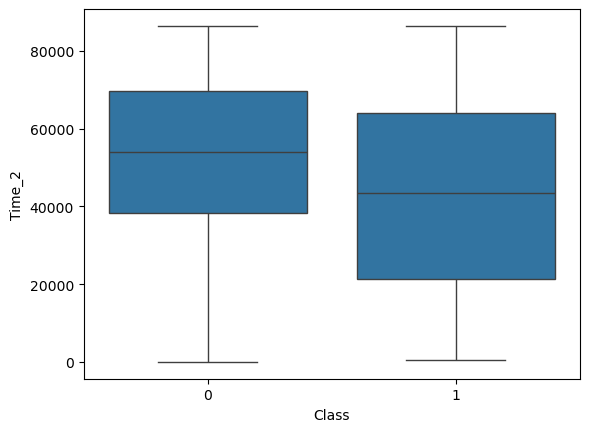

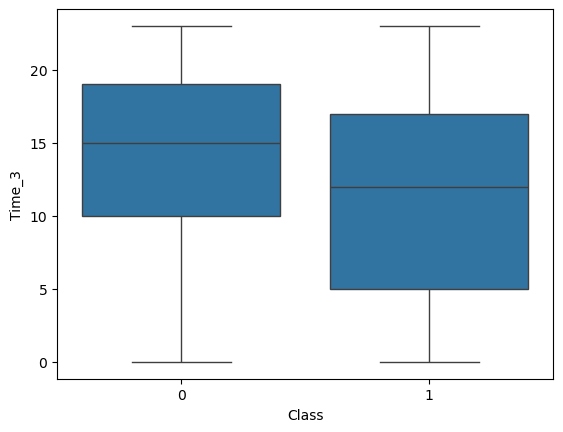

In [391]:
# Distribución bivariante de las variables contra la variable class

sns.pairplot(tarjetas,x_vars="Time_2",y_vars="Class")
plt.show()

sns.pairplot(tarjetas,x_vars="Time_3",y_vars="Class")
plt.show()

# Boxplot por clase
sns.boxplot(x="Class",y="Time_2",data=tarjetas)
plt.show()
sns.boxplot(x="Class",y="Time_3",data=tarjetas)
plt.show()

Calculamos la tasa de fraude por hora y generamos esa variable para potencialmente usarla en los modelos.

In [393]:
# Vamos a calcular la media de la variable class para cada hora
medias = tarjetas.groupby("Time_3")["Class"].mean().reset_index()
medias.rename(columns={"Class":"Time_4"},inplace=True)
medias

,Time_3,Time_4
0,0.0,0.000780
1,1.0,0.002370
2,2.0,0.017127
3,3.0,0.004868
4,4.0,0.010412
5,5.0,0.003679
6,6.0,0.002195
7,7.0,0.003175
8,8.0,0.000876
9,9.0,0.001010


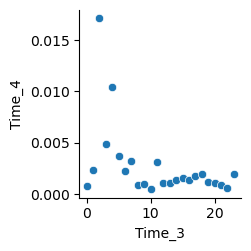

In [394]:
# Distribución cruzada
sns.pairplot(medias,x_vars="Time_3",y_vars="Time_4")
plt.show()

In [395]:
tarjetas = tarjetas.merge(medias,on="Time_3",how="left")

Se observa que hay mayores tasas de fraude en las primeras horas.

#### Variable Amount

In [398]:
# Descriptivos de las variables
tarjetas["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [399]:
# Vemos todos aquellos datos de Amount que son 0 para poder aplciar 0.01 para poder aplciarle el logaritmo para escalarlo entre 0 y 1
tarjetas[tarjetas["Amount"]==0]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,Time_2,Time_3,Time_4
383,282.0,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,...,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.0,0,282.0,0.0,0.00078
514,380.0,-1.299837,0.881817,1.452842,-1.293698,-0.025105,-1.170103,0.861610,-0.193934,0.592001,...,0.598930,-0.397705,0.637141,0.234872,0.021379,0.0,0,380.0,0.0,0.00078
534,403.0,1.237413,0.512365,0.687746,1.693872,-0.236323,-0.650232,0.118066,-0.230545,-0.808523,...,0.471218,0.289249,0.871803,-0.066884,0.012986,0.0,0,403.0,0.0,0.00078
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.320198,0.044519,0.177840,0.261145,-0.143276,0.0,1,406.0,0.0,0.00078
575,430.0,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,...,0.586664,-0.031598,0.570168,-0.043007,-0.223739,0.0,0,430.0,0.0,0.00078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283719,171817.0,-0.750414,0.904175,0.996461,0.427284,1.720336,0.929256,0.794272,0.176719,-1.836261,...,-0.186896,0.733759,2.558151,-0.188835,0.001654,0.0,0,85417.0,23.0,0.00192
283782,171870.0,2.083677,-0.065811,-1.442870,0.135416,0.043035,-1.306975,0.335835,-0.371635,0.730560,...,-0.082277,0.012887,-0.069278,-0.048995,-0.065482,0.0,0,85470.0,23.0,0.00192
283949,172027.0,2.132569,-0.057836,-1.724522,-0.030326,0.412146,-0.903088,0.345843,-0.348132,0.722638,...,-0.763831,0.117381,-0.027682,-0.047514,-0.071700,0.0,0,85627.0,23.0,0.00192
284085,172140.0,-2.210521,-1.039425,0.189704,-1.291932,3.742120,-1.665061,3.120388,-2.324089,0.364926,...,-0.268117,1.051309,0.334629,-1.930149,-0.899888,0.0,0,85740.0,23.0,0.00192


Hay 1825 con importe 0, lo susituimos por 0.01

In [401]:
tarjetas.loc[tarjetas["Amount"]==0,"Amount"]=0.01

In [402]:
tarjetas["Amount"].describe()

count    284807.000000
mean         88.349683
std         250.120087
min           0.010000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

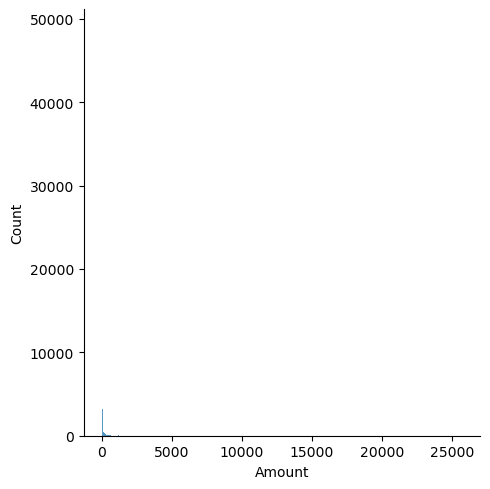

In [403]:
sns.displot(tarjetas["Amount"])
plt.show()

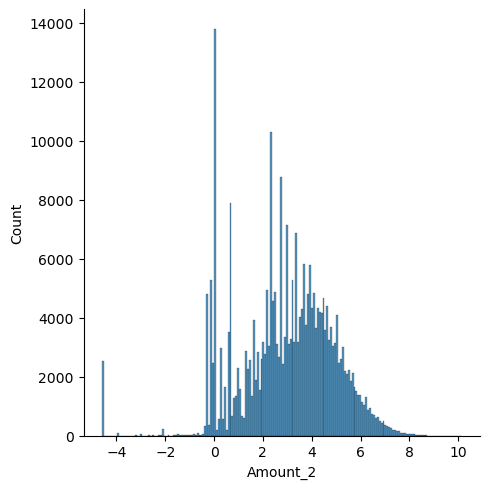

In [404]:
# Aplicamos logaritmo a la variable amount creando una nueva variable
tarjetas["Amount_2"]=np.log(tarjetas["Amount"])
sns.displot(tarjetas["Amount_2"])
plt.show()

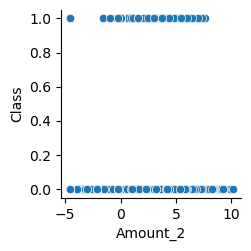

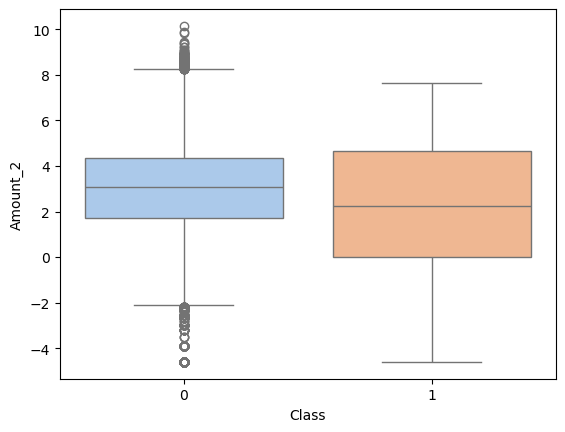

In [405]:
# Distribución bivariante de la variable contra la variable class

sns.pairplot(tarjetas,x_vars="Amount_2",y_vars="Class")
plt.show()

# Boxplot por clase
sns.boxplot(x="Class",y="Amount_2",data=tarjetas,palette="pastel")
plt.show()

In [406]:
# Vamos a dividir los disintos datos de Amount_2, es decir la cantidad escalada a 0 y 1, en deciles
tarjetas["Amount_2_decil"]=pd.qcut(tarjetas["Amount_2"],10,labels=False)
tarjetas["Amount_2_decil"]

0         8
1         1
2         9
3         8
4         7
         ..
284802    0
284803    5
284804    7
284805    3
284806    9
Name: Amount_2_decil, Length: 284807, dtype: int64

In [407]:
# Vamos a ccalcular la media de Class para cada decilç
media_decil=tarjetas.groupby("Amount_2_decil")["Class"].mean().reset_index()

media_decil.rename(columns={"Class":"Amount_3"},inplace=True)

media_decil

,Amount_2_decil,Amount_3
0,0,0.005936
1,1,0.001020
2,2,0.001261
3,3,0.000458
4,4,0.000488
5,5,0.000599
6,6,0.000846
7,7,0.001729
8,8,0.001604
9,9,0.002987


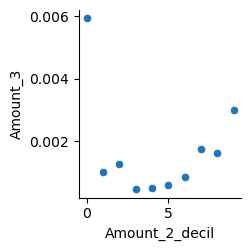

In [408]:
# Distribución cruzada
sns.pairplot(media_decil,x_vars="Amount_2_decil",y_vars="Amount_3")
plt.show()

Si calculamos la tasa de fraude por decilr de la variable amount, se osbervan diferencias: mayores tasas en cantidades menores y mayores, menores tasas en cantidades medias.

### 3. Enfoque tradicional

En este enfoque vamos a contruir un árbol de clasificación para predecir el fraude, tratándolo como un problema de clasificaión binaria más.

In [411]:
# Importación paquetes 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc

#### Preparación entrada modelo

Por un lado, elegimos sólo las variables que vamos a utilizar. Además, es necesario separar las variables independientes <b>X</b> de la variable dependiente <b>y</b>. Además de la separación de datos de entrenamiento y datos de testeo

In [413]:
tarjetas.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V26,V27,V28,Amount,Class,Time_2,Time_3,Time_4,Amount_2,Amount_2_decil
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0,0.00078,5.008099,8
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0,0.00078,0.989541,1
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.139097,-0.055353,-0.059752,378.66,0,1.0,0.0,0.00078,5.936639,9
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.221929,0.062723,0.061458,123.50,0,1.0,0.0,0.00078,4.816241,8
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.502292,0.219422,0.215153,69.99,0,2.0,0.0,0.00078,4.248352,7


In [414]:
# Nos debemos quedar solo con las variables originales, Amount_2 y Time_3

tarjetas_arbol = tarjetas[["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Class","Time_3","Amount_2"]]
tarjetas_arbol

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Time_3,Amount_2
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.0,5.008099
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.0,0.989541
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.0,5.936639
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.0,4.816241
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.0,4.248352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,23.0,-0.261365
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,23.0,3.210440
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,23.0,4.217741
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,23.0,2.302585


In [415]:
X = tarjetas_arbol.drop(["Class"],axis=1)
y = tarjetas["Class"]

In [416]:
(X_train,X_test,y_train,y_test)= train_test_split(X,y,test_size=0.3,random_state=123456789)


#### Estimación del arból de decision

In [418]:
classif_tree = DecisionTreeClassifier(max_depth=5)

In [419]:
classif_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [420]:
classif_tree.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [421]:
fpr,tpr,umbrales = roc_curve(y_test,classif_tree.predict_proba(X_test)[:,1],pos_label=1)

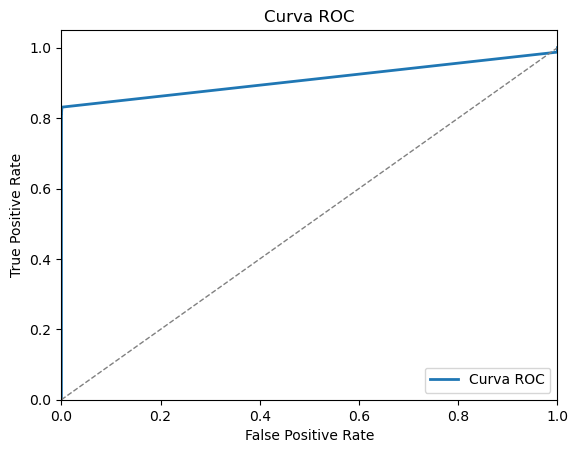

In [422]:
plt.figure()
lw = 2 
plt.plot(fpr,tpr,
         lw=lw,label="Curva ROC")
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [423]:
auc_1 = auc(fpr,tpr)
auc_1

0.9091996646459436

In [424]:
gini = 2*auc_1-1
gini

0.8183993292918872

Hemos conseguido un gini del 82%.

### 4. Enfoque Clustering

En este enfoque vamos a construir distintos clusters mediante el algorimto k-means, y vamos a utilizar la media de la tasa de fraude observada en cada cluster como predicción para una observación nueva.

In [427]:
# Importación de paquetes

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

#### Preparación entrada clustering

Por un lado, elegimos sólo las variables que vamos a utilizar. Además, es necesario separar las variables independientes <b>X</b> de la variable dependiente <b>y</b> y separar entre datos de testeo y datos de entrenamiento.

In [429]:
tarjetas

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V26,V27,V28,Amount,Class,Time_2,Time_3,Time_4,Amount_2,Amount_2_decil
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0,0.00078,5.008099,8
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0,0.00078,0.989541,1
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.139097,-0.055353,-0.059752,378.66,0,1.0,0.0,0.00078,5.936639,9
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.221929,0.062723,0.061458,123.50,0,1.0,0.0,0.00078,4.816241,8
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.502292,0.219422,0.215153,69.99,0,2.0,0.0,0.00078,4.248352,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.250034,0.943651,0.823731,0.77,0,86386.0,23.0,0.00192,-0.261365,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,-0.395255,0.068472,-0.053527,24.79,0,86387.0,23.0,0.00192,3.210440,5
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,-0.087371,0.004455,-0.026561,67.88,0,86388.0,23.0,0.00192,4.217741,7
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.546668,0.108821,0.104533,10.00,0,86388.0,23.0,0.00192,2.302585,3


In [430]:
tarjetas_clustering = tarjetas[["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Class","Time_3","Amount_2"]]
tarjetas_clustering

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Time_3,Amount_2
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.0,5.008099
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.0,0.989541
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.0,5.936639
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.0,4.816241
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.0,4.248352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,23.0,-0.261365
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,23.0,3.210440
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,23.0,4.217741
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,23.0,2.302585


In [431]:
X = tarjetas_clustering.drop(["Class"],axis=1)
y = tarjetas_clustering["Class"]

In [432]:
(X_train,X_test,y_train,y_test) = train_test_split(X,y,test_size=0.3,random_state=123456789)

#### Construcción clusters

Hacemos un primer clustering para ver que todo está ok, pero en realidad vamos a construir la curva de codo para elegir el número de clsuters que queremos.

In [434]:
kmeans = KMeans(n_clusters=3,n_init=50)
kmeans.fit(X_train)

KMeans(n_clusters=3, n_init=50)

Se obtienen los centros de los clusters.

In [436]:
kmeans.cluster_centers_

array([[-1.41805647e-03,  6.73275007e-02, -1.20273357e-03,
        -2.87473930e-02, -2.73489743e-02, -2.22644132e-02,
        -1.52863856e-02,  3.39654241e-02, -1.06263123e-01,
        -1.98394200e-03, -8.53371555e-02,  2.11970975e-01,
        -8.53727541e-02, -8.63918154e-02,  6.56577673e-02,
         6.07709802e-03, -2.72706743e-02,  6.67630528e-03,
         1.09940190e-02,  4.64151778e-03, -1.69224841e-02,
        -2.66291494e-02,  4.63943549e-03,  7.74027000e-03,
        -5.88289180e-03,  3.61970734e-03, -1.93727518e-03,
        -3.53550313e-03,  1.93428846e+01,  2.84656977e+00],
       [-4.12003783e-02,  3.08486052e-01,  2.58240102e-01,
         2.32356452e-01,  1.60586725e-01,  4.27018742e-02,
        -3.02128909e-02, -9.90550192e-02,  1.08022547e+00,
        -2.88348858e-01,  6.45671040e-01, -1.61756483e+00,
         1.06506380e+00,  8.48999145e-01, -4.13620101e-01,
        -3.66073442e-02,  3.06249068e-01,  1.19450014e-01,
        -8.46802175e-02, -3.61708091e-03, -5.45490087e-

In [437]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 2])

Obtenemos las distancias medias entre gurpos para distintos números de clusters, y enriquecemos así la elección "a priori" del número de clusters (cuando se aplana la curvas de codo). Como cada iteración requiere de cierto tiempo de procesamiento, calculamos entre 1 y 10 clusters en primer lugar.

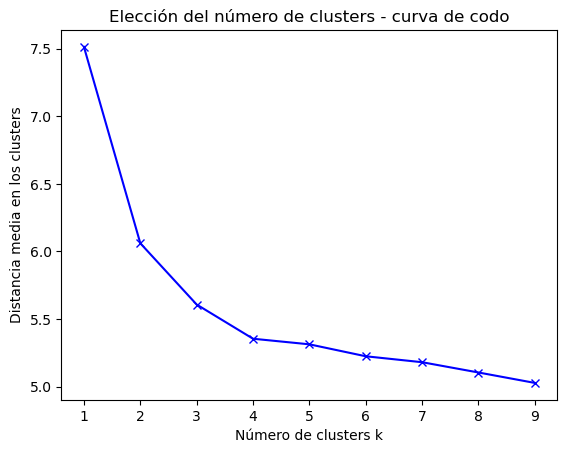

In [439]:
clusters = range(1,10)

desviaciones_medias=[]

for k in clusters:
    model=KMeans(n_clusters=k,n_init=25)
    model.fit(X_train)
    prediction=model.predict(X_train)
    desviaciones_medias.append(sum(np.min(cdist(X_train,model.cluster_centers_,"euclidean"),axis=1))/X_train.shape[0])
    

plt.cla()
plt.plot(clusters,desviaciones_medias,"bx-")
plt.xlabel('Número de clusters k')
plt.ylabel('Distancia media en los clusters')
plt.title('Elección del número de clusters - curva de codo')
plt.show()

Como la curva se aplana del caso con 4 a 5 clusters, nos podríamos quedar con 4 clsuters. Teniendo en cuenta que queremos separar distintos perfiles (necesitamos cierta granularidad, por lo que "cuantas más, mejor" en la medida que sea robusto), también nos podríamos quedan con 7, o con 11 si evaluamos hasta 20. Teniendo en cuenta esto, vamos a generar 7 clusters.

#### Puntuación y evaluación

Para poder evaluar este "modelo", en primer lugar medimos la tasa de fraude en cada uno de los clsutrers.

Sobre a muestra de valicación, asignamos cada observación al clsuter que le corresponda y, consecuentemente, le asignamos una tasa de fraude esperada, y evaluamos dicha predicción.

In [442]:
kmeans = KMeans(n_clusters=7,n_init=50)
kmeans.fit(X_train)

KMeans(n_clusters=7, n_init=50)

Se obitnene los centros de los clusters

In [444]:
kmeans.cluster_centers_

array([[ 9.26607343e-02,  6.43558285e-01, -6.82562696e-02,
         2.27548671e-01,  4.61834542e-01, -2.00395830e-01,
         1.80310050e-01, -5.97559806e-02, -1.17781357e-01,
        -9.92964777e-02, -4.03669807e-02,  2.15743495e-01,
        -1.44801969e-01, -1.16101439e-01,  8.13293493e-02,
         1.02950346e-01, -4.84802724e-02, -3.24412831e-02,
         1.24429946e-02, -5.34726357e-02, -1.42389001e-02,
        -3.21496115e-02, -2.24740648e-02,  1.18640675e-02,
        -2.09414849e-02,  3.65497751e-02,  5.12296081e-03,
         7.44195750e-03,  1.42715908e+01,  1.24398647e+00],
       [ 1.18738341e-01,  2.02606292e-01,  1.16606531e-01,
        -2.34441890e-02,  4.65491392e-02, -4.12359191e-02,
         4.06088863e-03,  2.63493556e-02, -1.30090225e-01,
        -6.85182844e-02, -7.18533453e-02,  2.28454055e-01,
        -6.55503099e-02, -8.98330919e-02,  8.93628003e-02,
         1.25876398e-02, -4.31566925e-02, -6.10649407e-03,
         2.77960573e-02, -2.73632465e-02, -3.06644853e-

In [445]:
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 0])

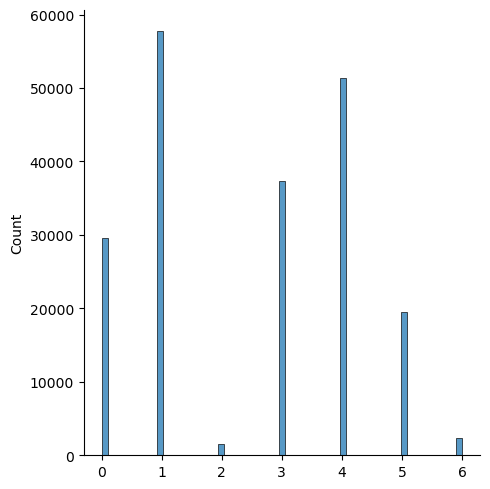

In [446]:
sns.displot(kmeans.labels_)
plt.show()

In [447]:
X_train["Cluster"] = kmeans.predict(X_train)
X_train["Class"] = y_train

In [448]:
# Tasas medias por número de outliersç
X_train.groupby('Cluster').agg(
    media_fraude=('Class', 'mean'),
    suma_fraude=('Class', 'sum'),
    contador_observaciones=('Class', 'count')
).reset_index()

,Cluster,media_fraude,suma_fraude,contador_observaciones
0,0,0.002197,65,29585
1,1,0.000883,51,57728
2,2,0.004657,7,1503
3,3,0.000830,31,37333
4,4,0.000662,34,51380
5,5,0.003175,62,19528
6,6,0.035544,82,2307


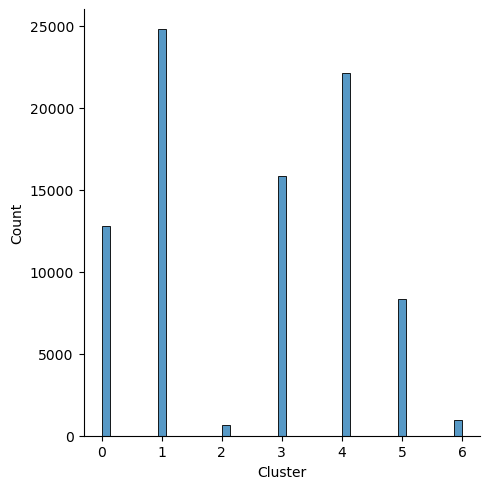

In [449]:
X_test['Cluster']=kmeans.predict(X_test)
sns.displot(X_test['Cluster'])
plt.show()

Para poder calcular el gini, no podemos usar directamente la variable "Cluster", porque las tasas de fraude esperadas (nuestra predicción) no están ordenadas. O bien cambiamos los valores de los clusters para tener orden en las tasas de fraude esperadas, o bien generamos una variable nueva con las tasas de fraude esperadas.

In [451]:
media = X_train.groupby("Cluster").agg( media_fraude=("Class","mean")).reset_index()

media

,Cluster,media_fraude
0,0,0.002197
1,1,0.000883
2,2,0.004657
3,3,0.000830
4,4,0.000662
5,5,0.003175
6,6,0.035544


In [452]:
X_test = X_test.merge(media,on="Cluster",how="left")

In [453]:
fpr,tpr,umbrales = roc_curve(y_test,X_test["media_fraude"],pos_label=1)

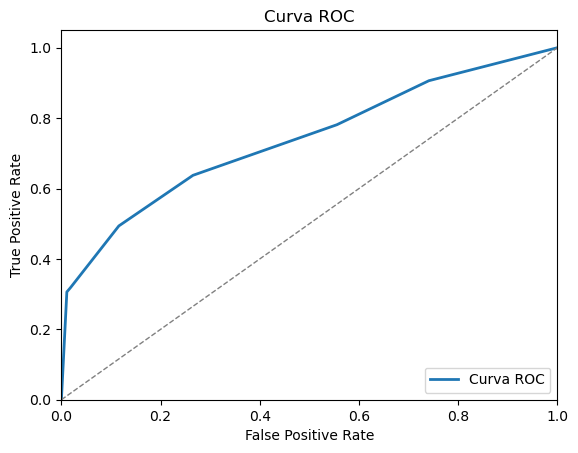

In [454]:
plt.figure()
lw = 2
plt.plot(fpr, tpr,
         lw=lw, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [455]:
auc_1=auc(fpr,tpr)
auc_1

0.7373774667870502

In [456]:
gini=2*auc_1-1
gini

0.47475493357410037

Hemos conseguido un Gini del 41%

### 5. Enfoque clases desbalanceadas 

En este enfoque vamos a construir un árbol de clasificación para predecir el fraude, pero lo estimaremos sobre una muestra ajustada para contemplar el fuerte desbalanceo entre las clases fraude y no fraude.

Las técnicas más habituales son:

* Oversampling: aumenta el número de observaciones "fraude" mediante duplicados aleatorios, pero puede generar sobreajuste.
* Undersampling: reduce el número de observaciones "no fraude", pero si pierde mucha información.
* SMOTE: aumenta el número de observaciones "fraude" generando nuevas observaciones sintéticas mediante técncias de interpolación, no generando tanto sobreajuste como en el caso de oversamplign.

In [459]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

#### Preparación entrada modelo

Por un lado, elegimos sólo las variables que vamos a utilizar. Además, es necesario separar las variables independeientes <b>X</b> de la dependiente <b>y</b> y los datos en datos de entrenamiento y de testeo.

In [461]:
# Nos quedamos sólo con las variables originales, Tiome_3(indicado de la hora) y Amount_2
tarjetas_arbol = tarjetas[["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Class","Time_3","Amount_2"]]
tarjetas_arbol

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Time_3,Amount_2
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.0,5.008099
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.0,0.989541
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.0,5.936639
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.0,4.816241
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.0,4.248352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,23.0,-0.261365
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,23.0,3.210440
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,23.0,4.217741
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,23.0,2.302585


In [462]:
X = tarjetas_arbol.drop("Class",axis=1)
y = tarjetas_arbol["Class"]

In [463]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123456789)

#### Aplicamos SMOTE

In [465]:
smote = SMOTE(random_state=123456789)
X_resampled,y_resampled = smote.fit_resample(X_train,y_train)

#### Estimamos el modelo

In [467]:
classif_tree = DecisionTreeClassifier(max_depth =5)
classif_tree.fit(X_resampled,y_resampled)

DecisionTreeClassifier(max_depth=5)

In [468]:
fpr,tpr,umbrales=roc_curve(y_test, classif_tree.predict_proba(X_test)[:,1], pos_label = 1)

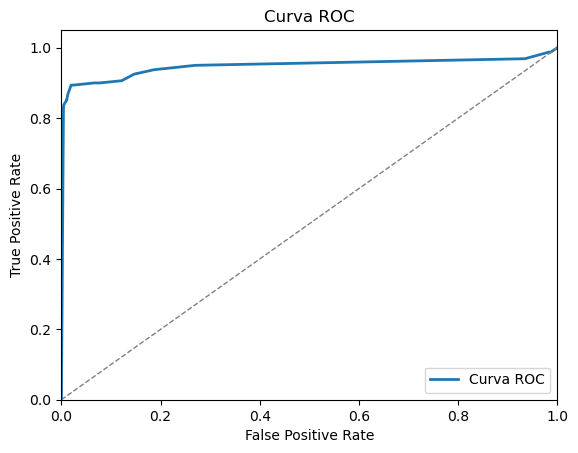

In [469]:
plt.figure()
lw = 2
plt.plot(fpr, tpr,
         lw=lw, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [470]:
auc_1=auc(fpr, tpr)
auc_1

0.9474688317132373

In [471]:
gini=2*auc_1-1
gini

0.8949376634264745

Conseguimos un gini del 88,25% y un accuracy del 94%.

#### 6. Enfoque detección de outliers

enfoque vamos a generar una variable que indicadores de outliers para cada variable (superior, inferior, outlier), y una variable que sume el número de outliers de cada observación. Para marcar outliers vamos a utilizar el método del <b>IQR</b>: se marcan outliers inferiores si están por debajo de <b>Q1-1.5·IQR</b> y superiores si están por encima de <b>Q3+1.5·IQR</b>.

A continuación, construiremos un árbol utilizando como variables candidatas únicamente los indicadores de outliers.

#### Generación marcas outliers

In [577]:
# Construimos una función para generar variables indicadores de outlier inferior/superior

def marcacion_outliers (df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    umbral_inf = Q1 - 1.5*IQR
    umbral_sup = Q3 + 1.5*IQR
    
    df[f"{column}_outlier_inf"] = (df[column] > umbral_sup).astype(int)
    df[f'{column}_outlier_sup'] = (df[column] < umbral_inf).astype(int)
    df[f'{column}_outlier'] = df[f'{column}_outlier_inf'] + df[f'{column}_outlier_sup']
    return df

In [579]:
tarjetas.iloc[: ,1:-7].columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

In [581]:
for i in tarjetas.iloc[: ,1:-7].columns:
    tarjetas_ouliers = marcacion_outliers(tarjetas,i)

In [585]:
tarjetas_outliers = marcacion_outliers(tarjetas, 'Amount_2')

In [589]:
# Generamos variable que acumula outliers
tarjetas_outliers['N_outliers']=tarjetas_outliers['V1_outlier']+tarjetas_outliers['V2_outlier']+tarjetas_outliers['V3_outlier']+tarjetas_outliers['V4_outlier']+\
    tarjetas_outliers['V5_outlier']+tarjetas_outliers['V6_outlier']+tarjetas_outliers['V7_outlier']+tarjetas_outliers['V8_outlier']+tarjetas_outliers['V9_outlier']+\
    tarjetas_outliers['V10_outlier']+tarjetas_outliers['V11_outlier']+tarjetas_outliers['V12_outlier']+tarjetas_outliers['V13_outlier']+tarjetas_outliers['V14_outlier']+\
    tarjetas_outliers['V15_outlier']+tarjetas_outliers['V16_outlier']+tarjetas_outliers['V17_outlier']+tarjetas_outliers['V18_outlier']+tarjetas_outliers['V19_outlier']+\
    tarjetas_outliers['V20_outlier']+tarjetas_outliers['V21_outlier']+tarjetas_outliers['V22_outlier']+tarjetas_outliers['V23_outlier']+tarjetas_outliers['V24_outlier']+\
    tarjetas_outliers['V25_outlier']+tarjetas_outliers['V26_outlier']+tarjetas_outliers['V27_outlier']+tarjetas_outliers['V28_outlier']+tarjetas_outliers['Amount_2_outlier']

<function matplotlib.pyplot.show(close=None, block=None)>

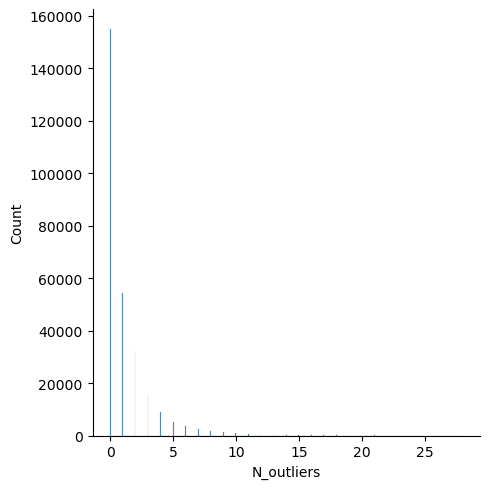

In [593]:
# Distribución 

sns.displot(tarjetas_outliers["N_outliers"])
plt.show

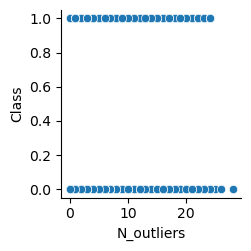

In [597]:
# Distribución bivariante de las variables contra la variable class
sns.pairplot(tarjetas_outliers,x_vars="N_outliers",y_vars="Class")
plt.show()

In [599]:
# Tasas medias por número de outliers

medias = tarjetas_outliers.groupby("N_outliers").agg(
    media_fraude = ("Class","mean"),
    suma_fraude = ("Class","sum"),
    contador_observaciones = ("Class","count")).reset_index()

medias

,N_outliers,media_fraude,suma_fraude,contador_observaciones
0,0,0.000084,13,154892
1,1,0.000330,18,54542
2,2,0.000404,13,32175
3,3,0.001202,19,15802
4,4,0.000984,9,9144
5,5,0.002073,11,5307
6,6,0.002547,9,3534
7,7,0.006080,15,2467
8,8,0.017581,33,1877
9,9,0.014015,20,1427


In [601]:
# Para garantizar la monotonía, se agregan las observaciones con 3 9 4 outliers, con 8 o 9, con 19 o 20 y con +20
tarjetas_outliers.loc[tarjetas_outliers['N_outliers'] == 4, 'N_outliers'] = 3
tarjetas_outliers.loc[tarjetas_outliers['N_outliers'] == 9, 'N_outliers'] = 8
tarjetas_outliers.loc[tarjetas_outliers['N_outliers'] == 20, 'N_outliers'] = 19
tarjetas_outliers.loc[tarjetas_outliers['N_outliers'] > 20, 'N_outliers'] = 21

#### Preparación entrada modelo

In [605]:
tarjetas_outliers_aux=tarjetas_outliers.iloc[:, 37:-1]
tarjetas_outliers_aux['Class'] = tarjetas_outliers['Class']
tarjetas_outliers_aux

,V1_outlier_sup,V1_outlier,V2_outlier_inf,V2_outlier_sup,V2_outlier,V3_outlier_inf,V3_outlier_sup,V3_outlier,V4_outlier_inf,V4_outlier_sup,...,V27_outlier_inf,V27_outlier_sup,V27_outlier,V28_outlier_inf,V28_outlier_sup,V28_outlier,Amount_2_outlier_inf,Amount_2_outlier_sup,Amount_2_outlier,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1,1,1,0,1,0,1,1,0,0,...,1,0,1,1,0,1,0,0,0,0
284803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
284804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
284805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [607]:
X = tarjetas_outliers_aux.drop("Class",axis=1)
y = tarjetas_outliers_aux["Class"]

In [609]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123456789)

#### Modelo árbol de outliers

In [612]:
classif_tree = DecisionTreeClassifier(max_depth=9)
classif_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9)

In [614]:
classif_tree.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Calculamos la matriz de confusión, algunas métricas de evaluación habituales y el coeficiente AUC o ROC y e gini para el modelo estimado.

<Axes: >

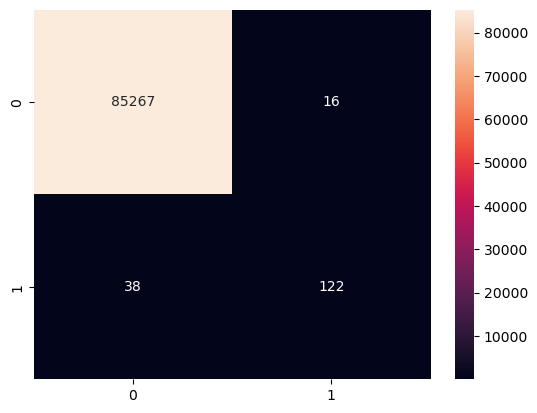

In [617]:
cm = confusion_matrix(y_test, classif_tree.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d")

In [619]:
print(classification_report(y_test,classif_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85283
           1       0.88      0.76      0.82       160

    accuracy                           1.00     85443
   macro avg       0.94      0.88      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [621]:
fpr,tpr,umbrales=roc_curve(y_test, classif_tree.predict_proba(X_test)[:,1], pos_label = 1)

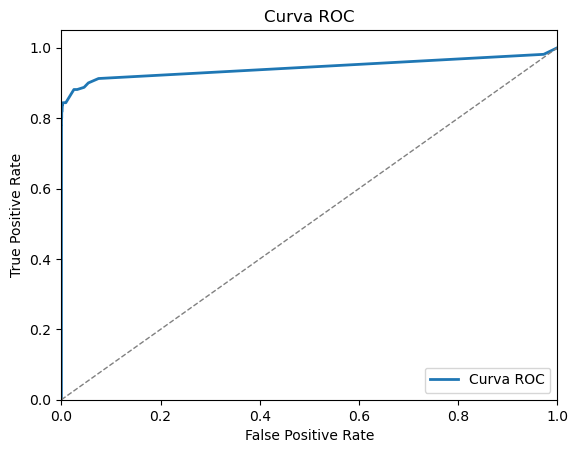

In [623]:
plt.figure()
lw = 2
plt.plot(fpr, tpr,
         lw=lw, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [625]:
auc_1=auc(fpr, tpr)
auc_1

0.9430619598864954

In [627]:
gini=2*auc_1-1
gini

0.8861239197729909

El Gini es del 88%.